# Part I (Bootstrapping Swap Curves)

## Installation

In [1]:
import pandas as pd
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import fsolve
import matplotlib.pyplot as plt
import warnings
import os  

warnings.filterwarnings('ignore')

In [2]:
def ois_rate(rate, year):
    rate = 1 / ((1 + rate/360)**(360*year))
    return rate

def float_rate(rate, year):
    rate = ((1 + rate/360)**(360*year)) - 1
    return rate

def fix_rate(data_semi,data_irs,end,current_index):
    fixrate=data_semi.loc[data_semi.index<end,'OIS_Discount'].sum()*data_irs.loc[data_irs.index==current_index,'Rate'].values[0]
    return fixrate

def floating_rate(start_date,tenor,semi_df):
    floatrate=np.zeros(tenor)
    floatrate[start_date]=semi_df.loc[semi_df.index==start_date,'OIS_Discount'].values[0]*2*(1/semi_df.loc[semi_df.index==start_date,'lbs_Discount'].values[0] -1)
    for i in range(1,tenor):
        floatrate[i]=semi_df.loc[semi_df.index==i,'OIS_Discount'].values[0]*2*(semi_df.loc[semi_df.index==i-1,'lbs_Discount'].values[0]/semi_df.loc[semi_df.index==i,'lbs_Discount'].values[0] -1)
    return floatrate

def f(x):
        calibration=np.zeros(diff)
        calibration_1=np.zeros(diff+1)
        calibration_1[0]=data_semi.loc[data_semi.index == tenor,'OIS_Discount'].values[0]*2*(data_semi.loc[data_semi.index==tenor-1,'lbs_Discount'].values[0]/x[0] -1)
        for j in range(diff-1):
            calibration_1[j+1]=data_semi.loc[data_semi.index == tenor+j+1,'OIS_Discount'].values[0]*2*(x[j]/x[j+1] -1)
            if j>0:
                calibration[j+1]=2*x[j]-x[j+1]-x[j-1]
            else:
                calibration[j+1]=2*x[j]-x[j+1]-data_semi.loc[data_semi.index==tenor-1,'lbs_Discount'].values[0]
        calibration[0]=fixrate-np.sum(floatrate[0:tenor])-np.sum(calibration_1[0:diff+1])
        return calibration

## OIS Discount Factor

In [3]:
data = pd.read_excel('IR Data.xlsx', sheet_name = 'OIS')
data = data[['Tenor','Product','Rate']]
data.loc[data['Tenor'] == '6m','Tenor'] = '99y'
##convert to years
data['Tenor'] = data['Tenor'].str.extract('(\d+)')
data.Tenor = data.Tenor.astype(float)
##convert to number form
data.loc[data['Tenor'] == 99,'Tenor'] = 0.5

##calculate discount factor
data['float'] = np.nan
data['OIS_Discount'] = np.nan

data.loc[data.Tenor<2, 'float'] = ((data.Rate +1)**(1/data.Tenor/360)-1)*(360*data.Tenor)
data.OIS_Discount = ois_rate(data.float,data.Tenor)

#
data['Tenor_diff'] = data['Tenor'] - data['Tenor'].shift(1)

for i in range(2, len(data)):
    a = data.loc[data.index == i-1, 'Tenor'].values[0] 
    b = data.loc[data.index == i, 'Tenor'].values[0] 
    array = data.loc[1:i-1,'OIS_Discount'].values
    
    data.loc[(data.index == i) & (data.Tenor_diff == 1), 'float'] = fsolve(lambda x: ((np.sum(array) + array[-1] * ois_rate(x, 1)) * data.loc[data.Tenor == b, 'Rate'].values[0]) -
                                   1 + array[-1] * ois_rate(x, 1), 0.001)[0]
    
    data.loc[(data.index == i) & (data.Tenor_diff > 1), 'float'] = fsolve(lambda x: ((np.sum(array) + array[-1] * 
                                    np.sum([ois_rate(x, j) for j in range(1, int(b-a)+1)])) *
                                    data.loc[data.Tenor == b, 'Rate'].values[0]) - (1 - array[-1] * ois_rate(x, b-a)), 0.001)
    
    data.loc[data.index == i, 'OIS_Discount'] = (data.loc[data.Tenor == a, 'OIS_Discount'].values[0] * ois_rate(data.loc[data.index == i, 'float'].values[0], b-a))

data

,Tenor,Product,Rate,float,OIS_Discount,Tenor_diff
0,0.5,OIS,0.00250,0.002497,0.998752,NaN
1,1.0,OIS,0.00300,0.002996,0.997009,0.5
2,2.0,OIS,0.00325,0.003495,0.993531,1.0
3,3.0,OIS,0.00335,0.003545,0.990015,1.0
4,4.0,OIS,0.00350,0.003946,0.986117,1.0
5,5.0,OIS,0.00360,0.003996,0.982184,1.0
6,7.0,OIS,0.00400,0.005003,0.972406,2.0
7,10.0,OIS,0.00450,0.004163,0.960336,3.0
8,15.0,OIS,0.00500,0.003885,0.941861,5.0
9,20.0,OIS,0.00525,0.001607,0.934322,5.0


In [4]:
data_semi = pd.DataFrame(columns = ['Rate','float','OIS_Discount'],index = np.arange(data.Tenor.min(),data.Tenor.max()+0.5,0.5))
data_semi.index.name = 'Tenor'
data_semi['Rate'] = data.set_index('Tenor')['Rate']
data_semi['float'] = data.set_index('Tenor')['float']
data_semi['OIS_Discount'] = data.set_index('Tenor')['OIS_Discount']
data_semi[['float']] = data_semi[['float']].fillna(method = 'bfill')
data_semi = data_semi.reset_index()
for i in range(1, len(data_semi)):
    if pd.isna(data_semi.loc[data_semi.index == i,'OIS_Discount'].values[0]):
        data_semi.loc[data_semi.index == i, 'OIS_Discount'] = data_semi.loc[data_semi.index == i-1, 'OIS_Discount'].values[0] * ois_rate(data_semi.loc[data_semi.index == i, 'float'], 0.5)
data_semi.head()

,Tenor,Rate,float,OIS_Discount
0,0.5,0.00250,0.002497,0.998752
1,1.0,0.00300,0.002996,0.997009
2,1.5,NaN,0.003495,0.995268
3,2.0,0.00325,0.003495,0.993531
4,2.5,NaN,0.003545,0.991771


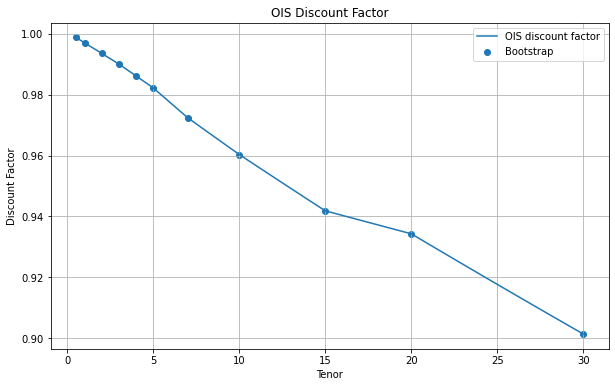

In [5]:
plt.figure(figsize = (10,6))
plt.scatter(data.Tenor,data['OIS_Discount'], label = 'Bootstrap', marker = 'o')
plt.plot(data_semi.Tenor,data_semi['OIS_Discount'],  label = 'OIS discount factor')
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')
plt.title('OIS Discount Factor')
plt.legend()
plt.grid()
plt.show()

## IRS Discount Factor

In [6]:
#data_semi
data_irs = pd.read_excel('IR Data.xlsx', sheet_name = 'IRS')
data_irs = data_irs[['Tenor','Product','Rate']]
data_irs.loc[data_irs['Tenor'] == '6m','Tenor'] = '99y'
##convert to years
data_irs['Tenor'] = data_irs['Tenor'].str.extract('(\d+)')
data_irs.Tenor = data_irs.Tenor.astype(float)
##convert to number form
data_irs.loc[data_irs['Tenor'] == 99,'Tenor'] = 0.5
##calculate discount factor
data_irs['lbs_Discount'] = np.nan
##0.5 year
data_irs.loc[data_irs.Tenor== 0.5, 'lbs_Discount'] = 1/(1+ data_irs.loc[data_irs.Tenor==0.5, 'Rate'].values[0]/2)
##1 year
d0_05 = data_semi.loc[data_semi.Tenor== 0.5, 'OIS_Discount'].values[0]
d0_1 = data_semi.loc[data_semi.Tenor== 1, 'OIS_Discount'].values[0]
d05 =  data_irs.loc[data_irs.Tenor== 0.5, 'lbs_Discount'].values[0]
r1 =  data_irs.loc[data_irs.Tenor== 1, 'Rate'].values[0]
t1 = ((d0_05+d0_1)*r1-(d0_05*2*(1/d05-1))) / (d0_1*2) + 1
data_irs.loc[data_irs.Tenor== 1, 'lbs_Discount']  =   d05/t1
##after 1 year
data_irs['Tenor_diff'] = data_irs['Tenor'] - data_irs['Tenor'].shift(1)
data_semi = data_semi.set_index('Tenor')
data_semi['lbs_rate'] = data_irs.set_index('Tenor')['Rate']
data_semi['lbs_Discount'] = data_irs.set_index('Tenor')['lbs_Discount']
data_semi = data_semi.reset_index()

In [7]:
for i in range(2, len(data_irs)):
    a = data_irs.loc[data_irs.index == i-1, 'Tenor'].values[0] 
    b = data_irs.loc[data_irs.index == i, 'Tenor'].values[0] 
    tenor = int(a)*2
    end = int(b)*2
    df = data_semi
    fixrate = fix_rate(data_semi,data_irs,end,i)
    floatrate = floating_rate(0,tenor,data_semi)
    diff = (end - tenor)
    data_semi.iloc[tenor:end]['lbs_Discount'] = fsolve(f,np.ones(diff))

data_semi['forward_libor'] = np.nan    
data_semi.loc[data_semi.index == 0 ,'forward_libor'] = data_semi.loc[data_semi.index == 0 ,'lbs_rate'].values[0]
for i in range(1,len(data_semi)):
    a0 = data_semi.loc[data_semi.index == i-1 ,'lbs_Discount'].values[0]
    a1 = data_semi.loc[data_semi.index == i ,'lbs_Discount'].values[0]
    data_semi.loc[data_semi.index == i ,'forward_libor']=2 * ( a0/a1 -1 )
data_semi.to_csv(os.getcwd() + r'\data_semi.csv')    
data_semi.head()

,Tenor,Rate,float,OIS_Discount,lbs_rate,lbs_Discount,forward_libor
0,0.5,0.00250,0.002497,0.998752,0.025,0.987654,0.025000
1,1.0,0.00300,0.002996,0.997009,0.028,0.972577,0.031005
2,1.5,NaN,0.003495,0.995268,NaN,0.957378,0.031751
3,2.0,0.00325,0.003495,0.993531,0.030,0.942179,0.032263
4,2.5,NaN,0.003545,0.991771,NaN,0.926330,0.034218


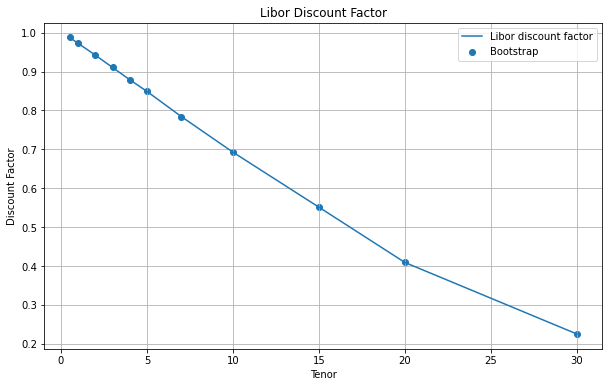

In [8]:
plt.figure(figsize = (10,6))
plt.scatter(data_semi.loc[data_semi.Tenor.isin(data_irs.Tenor),'Tenor'],data_semi.loc[data_semi.Tenor.isin(data_irs.Tenor),'lbs_Discount'], label = 'Bootstrap', marker = 'o')
plt.plot(data_semi.Tenor,data_semi['lbs_Discount'],  label = 'Libor discount factor')
plt.xlabel('Tenor')
plt.ylabel('Discount Factor')
plt.title('Libor Discount Factor')
plt.legend()
plt.grid()
plt.show()

## Forward Swap Rates

In [9]:
forward_swap_df = pd.DataFrame()
forward_swap_df['Expiry'] = [1,1,1,1,1,5,5,5,5,5,10,10,10,10,10]
forward_swap_df['Tenor'] = [1,2,3,5,10,1,2,3,5,10,1,2,3,5,10]
# forward_swap_df['forward_swap'] = np.nan
# forward_swap_df['forward_swap'] = forward_swap_df['forward_swap'].astype(float)
for i in range(0,len(forward_swap_df)):
    exp_num = int(forward_swap_df.iloc[i]['Expiry'])*2
    tn_num = int(forward_swap_df.iloc[i]['Tenor'])*2
    fix_leg = 0.5*data_semi.loc[(data_semi.index>=exp_num)&(data_semi.index<(exp_num+tn_num))]['OIS_Discount'].sum()
    flt_np = np.zeros(tn_num)
    for j in range(0,tn_num):
        flt_np[j] = data_semi.iloc[exp_num+j]['OIS_Discount']*data_semi.iloc[exp_num+j]['forward_libor']
    flt_leg = 0.5 * np.sum(flt_np)
#     print(flt_leg)
    forward_swap_df.loc[forward_swap_df.index==i,'forward_swap']= flt_leg/fix_leg

forward_swap_df.to_csv(os.getcwd() + r'\forward_swap.csv')
forward_swap_df    

,Expiry,Tenor,forward_swap
0,1,1,0.032007
1,1,2,0.033259
2,1,3,0.034011
3,1,5,0.035255
4,1,10,0.038424
5,5,1,0.039274
6,5,2,0.040075
7,5,3,0.040068
8,5,5,0.041087
9,5,10,0.043612


## Forward Rate for half Year

In [10]:
forward_swap_df_6m = pd.DataFrame()
forward_swap_df_6m['Expiry'] = [0.5,0.5,0.5,0.5,0.5,1,1,1,1,1,2,2,2,2,2,5,5,5,5,5,8,8,8,8,8,10,10,10,10,10]
forward_swap_df_6m['Tenor'] = [1,2,3,5,10,1,2,3,5,10,1,2,3,5,10,1,2,3,5,10,1,2,3,5,10,1,2,3,5,10]
# forward_swap_df['forward_swap'] = np.nan
# forward_swap_df['forward_swap'] = forward_swap_df['forward_swap'].astype(float)
for i in range(0,len(forward_swap_df_6m)):
    exp_num = int(forward_swap_df_6m.iloc[i]['Expiry'])*2
    tn_num = int(forward_swap_df_6m.iloc[i]['Tenor'])*2
    fix_leg = 0.5*data_semi.loc[(data_semi.index>=exp_num)&(data_semi.index<(exp_num+tn_num))]['OIS_Discount'].sum()
    flt_np = np.zeros(tn_num)
    for j in range(0,tn_num):
        flt_np[j] = data_semi.iloc[exp_num+j]['OIS_Discount']*data_semi.iloc[exp_num+j]['forward_libor']
    flt_leg = 0.5 * np.sum(flt_np)
#     print(flt_leg)
    forward_swap_df_6m.loc[forward_swap_df_6m.index==i,'forward_swap']= flt_leg/fix_leg

forward_swap_df_6m.to_csv(os.getcwd() + r'\forward_swap_6m.csv')
forward_swap_df_6m    

,Expiry,Tenor,forward_swap
0,0.5,1,0.028000
1,0.5,2,0.030000
2,0.5,3,0.031500
3,0.5,5,0.033000
4,0.5,10,0.037000
5,1.0,1,0.032007
6,1.0,2,0.033259
7,1.0,3,0.034011
8,1.0,5,0.035255
9,1.0,10,0.038424


# Quarterly

In [11]:
data_quarter = pd.DataFrame(columns = ['Rate','float','OIS_Discount'],index = np.arange(0.25,data.Tenor.max()+0.25,0.25))
data_quarter.index.name = 'Tenor'
data_quarter['Rate'] = data.set_index('Tenor')['Rate']
data_quarter['float'] = data.set_index('Tenor')['float']
data_quarter['OIS_Discount'] = data.set_index('Tenor')['OIS_Discount']
data_quarter[['float']] = data_quarter[['float']].fillna(method = 'bfill')
data_quarter = data_quarter.reset_index()
for i in range(1, len(data_quarter)):
    if pd.isna(data_quarter.loc[data_quarter.index == i,'OIS_Discount'].values[0]):
        data_quarter.loc[data_quarter.index == i, 'OIS_Discount'] = data_quarter.loc[data_quarter.index == i-1, 'OIS_Discount'].values[0] * ois_rate(data_quarter.loc[data_quarter.index == i, 'float'], 0.25)

data_quarter.loc[data_quarter.Tenor == 0.25,'OIS_Discount'] =   data_quarter.loc[data_quarter.Tenor == 0.5, 'OIS_Discount'].values[0] / ois_rate(data_quarter.loc[data_quarter.Tenor == 0.50, 'float'].values[0], 0.25)
      
# data_quarter.to_csv(os.getcwd() + r'\data_quarterly.csv')
data_quarter

,Tenor,Rate,float,OIS_Discount
0,0.25,NaN,0.002497,0.999376
1,0.50,0.0025,0.002497,0.998752
2,0.75,NaN,0.002996,0.998005
3,1.00,0.0030,0.002996,0.997009
4,1.25,NaN,0.003495,0.996138
...,...,...,...,...
115,29.00,NaN,0.003582,0.904679
116,29.25,NaN,0.003582,0.903870
117,29.50,NaN,0.003582,0.903060
118,29.75,NaN,0.003582,0.902252


In [12]:
data_quarter = data_quarter.set_index('Tenor')
data_quarter['lbs_rate'] = data_semi.set_index('Tenor')['lbs_rate']
data_quarter['lbs_Discount'] = data_semi.set_index('Tenor')['lbs_Discount']
data_quarter = data_quarter.reset_index()
data_quarter.loc[data_quarter.index==0,'lbs_Discount']=((data_quarter.iloc[1]['lbs_Discount']+1)/2)
data_quarter.lbs_Discount = data_quarter.lbs_Discount.interpolate()
data_quarter['forward_libor'] = ( 1/data_quarter.lbs_Discount -1 ) / data_quarter.Tenor
for i in range(1,len(data_quarter)):
    data_quarter.loc[data_quarter.index == i, 'forward_libor'] = 4 * (data_quarter.loc[data_quarter.index == i-1, 'lbs_Discount'].values[0] /data_quarter.loc[data_quarter.index == i, 'lbs_Discount'].values[0] -1)

data_quarter.to_csv(os.getcwd() + r'\data_quarterly.csv')   
data_quarter.tail(20)

,Tenor,Rate,float,OIS_Discount,lbs_rate,lbs_Discount,forward_libor
100,25.25,NaN,0.003582,0.916914,NaN,0.312633,0.058816
101,25.50,NaN,0.003582,0.916094,NaN,0.308036,0.059694
102,25.75,NaN,0.003582,0.915274,NaN,0.303439,0.060598
103,26.00,NaN,0.003582,0.914454,NaN,0.298842,0.061530
104,26.25,NaN,0.003582,0.913636,NaN,0.294245,0.062491
105,26.50,NaN,0.003582,0.912818,NaN,0.289648,0.063483
106,26.75,NaN,0.003582,0.912001,NaN,0.285051,0.064507
107,27.00,NaN,0.003582,0.911184,NaN,0.280454,0.065564
108,27.25,NaN,0.003582,0.910369,NaN,0.275857,0.066657
109,27.50,NaN,0.003582,0.909554,NaN,0.271260,0.067787
